<a href="https://colab.research.google.com/github/juantijero/ML_HW/blob/main/Used_Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- BLOCK 1: LOAD & CLEAN ---
import kagglehub
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("--- Step 1: Loading Data ---")
path = kagglehub.dataset_download("adityadesai13/used-car-dataset-ford-and-mercedes")
all_files = glob.glob(os.path.join(path, "*.csv"))

df_list = []
for filename in all_files:
    df = pd.read_csv(filename)
    df['manufacturer'] = os.path.basename(filename).split('.')[0].capitalize()
    if 'tax(£)' in df.columns: df.rename(columns={'tax(£)': 'tax'}, inplace=True)
    df_list.append(df)

master_df = pd.concat(df_list, ignore_index=True)
df = master_df.copy()

# Fix Text Columns
df['price'] = pd.to_numeric(df['price'].astype(str).str.replace('£', '').str.replace(',', ''), errors='coerce')
df['mileage'] = pd.to_numeric(df['mileage'].astype(str).str.replace(',', ''), errors='coerce')
df.dropna(subset=['price', 'tax', 'mpg'], inplace=True)
df['engineSize'] = df['engineSize'].replace(0, df['engineSize'].median())

# Remove Outliers (Top/Bottom 1%)
q_low = df['price'].quantile(0.01)
q_hi  = df['price'].quantile(0.99)
df = df[(df['price'] > q_low) & (df['price'] < q_hi)]

print(f"Data Cleaned. Rows: {len(df)}. Price Range: £{q_low:,.0f} - £{q_hi:,.0f}")

--- Step 1: Loading Data ---
Using Colab cache for faster access to the 'used-car-dataset-ford-and-mercedes' dataset.
Data Cleaned. Rows: 97143. Price Range: £3,995 - £52,000


In [2]:
# --- BLOCK 2: FEATURES & SPLIT ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("--- Step 2: Engineering Features ---")

# 1. Create Age
if 'year' in df.columns:
    df['car_age'] = 2025 - df['year']
    df.drop(columns=['year'], inplace=True)

# 2. Select & Encode
keep_cols = ['model', 'transmission', 'fuelType', 'manufacturer', 'mileage', 'tax', 'mpg', 'engineSize', 'car_age', 'price']
df_clean = df[keep_cols].copy()
df_processed = pd.get_dummies(df_clean, columns=['model', 'transmission', 'fuelType', 'manufacturer'], drop_first=True)

# 3. Scale Inputs
scaler = StandardScaler()
num_cols = ['mileage', 'tax', 'mpg', 'engineSize', 'car_age']
df_processed[num_cols] = scaler.fit_transform(df_processed[num_cols])

# 4. Split
X = df_processed.drop('price', axis=1).astype(float)
y = df_processed['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}")

--- Step 2: Engineering Features ---
Training Data Shape: (77714, 201)


In [3]:
# --- BLOCK 3: LINEAR REGRESSION ---
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

print("--- Step 3: Linear Baseline ---")
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"Linear RMSE: £{rmse_lr:,.2f}")

--- Step 3: Linear Baseline ---
Linear RMSE: £2,828.24


In [4]:
# --- BLOCK 4: PYTORCH PREP ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

print("--- Step 4: Tensors & Scaling ---")

# Scale Targets
y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

# Create Tensors
X_train_tensor = torch.tensor(X_train.values).float()
X_test_tensor = torch.tensor(X_test.values).float()
y_train_tensor = torch.tensor(y_train_scaled).float()
y_test_tensor = torch.tensor(y_test_scaled).float()

print("Tensors Ready.")

--- Step 4: Tensors & Scaling ---
Tensors Ready.


In [5]:
# --- BLOCK 5: FCNN TRAINING ---
print("--- Step 5: Training FCNN ---")

class CarFCNN(nn.Module):
    def __init__(self, input_dim):
        super(CarFCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU(),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

model_fcnn = CarFCNN(X_train.shape[1])
optimizer = optim.Adam(model_fcnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

loss_history_fcnn = []
best_loss = float('inf')
patience = 20
counter = 0

for epoch in range(500):
    model_fcnn.train()
    y_pred = model_fcnn(X_train_tensor)
    loss = criterion(y_pred, y_train_tensor)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation (for Early Stopping)
    model_fcnn.eval()
    with torch.no_grad():
        val_loss = criterion(model_fcnn(X_test_tensor), y_test_tensor).item()
    loss_history_fcnn.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"Early Stopping at Epoch {epoch+1}")
            break

model_fcnn.eval()
with torch.no_grad():
    pred_fcnn = y_scaler.inverse_transform(model_fcnn(X_test_tensor).numpy())
rmse_fcnn = np.sqrt(mean_squared_error(y_test, pred_fcnn))
print(f"FCNN RMSE: £{rmse_fcnn:,.2f}")

--- Step 5: Training FCNN ---
FCNN RMSE: £1,658.59


In [6]:
# --- BLOCK 6: CNN TRAINING ---
print("--- Step 6: Training CNN ---")

# 1. Data Loader (Mini-Batching)
# We use batches of 64 to stop memory crashes
X_train_cnn = X_train_tensor.unsqueeze(1) # [Batch, 1, Features]
X_test_cnn = X_test_tensor.unsqueeze(1)
train_loader = DataLoader(TensorDataset(X_train_cnn, y_train_tensor), batch_size=64, shuffle=True, drop_last=True)

# 2. Model
class CarCNN(nn.Module):
    def __init__(self, num_features):
        super(CarCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 32, 3, padding=1), nn.BatchNorm1d(32), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(32, 64, 3, padding=1), nn.BatchNorm1d(64), nn.ReLU(), nn.MaxPool1d(2),
            nn.Conv1d(64, 128, 3, padding=1), nn.BatchNorm1d(128), nn.ReLU(), nn.MaxPool1d(2)
        )
        # Auto-calculate flat size using a dummy pass
        with torch.no_grad():
            dummy = torch.zeros(1, 1, num_features)
            self.flat_size = self.features(dummy).view(1, -1).shape[1]

        self.regressor = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flat_size, 128), nn.ReLU(), nn.Dropout(0.4),
            nn.Linear(128, 1)
        )
    def forward(self, x): return self.regressor(self.features(x))

# 3. Train
model_cnn = CarCNN(X_train.shape[1])
optimizer = optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = nn.MSELoss()

loss_history_cnn = []
best_loss = float('inf')
counter = 0

for epoch in range(150):
    model_cnn.train()
    batch_losses = []
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        out = model_cnn(inputs)
        loss = criterion(out, targets)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    # Validation
    model_cnn.eval()
    with torch.no_grad():
        val_loss = criterion(model_cnn(X_test_cnn), y_test_tensor).item()
    loss_history_cnn.append(val_loss)

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= 15:
            print(f"Early Stopping at Epoch {epoch+1}")
            break

    if (epoch+1) % 25 == 0: print(f"Epoch {epoch+1} Val Loss: {val_loss:.4f}")

# 4. Evaluate
model_cnn.eval()
with torch.no_grad():
    pred_cnn = y_scaler.inverse_transform(model_cnn(X_test_cnn).numpy())
rmse_cnn = np.sqrt(mean_squared_error(y_test, pred_cnn))
print(f"CNN RMSE: £{rmse_cnn:,.2f}")

--- Step 6: Training CNN ---
Epoch 25 Val Loss: 0.0468
Epoch 50 Val Loss: 0.0461
Epoch 75 Val Loss: 0.0419
Epoch 100 Val Loss: 0.0424
Early Stopping at Epoch 104
CNN RMSE: £1,767.57


In [13]:
# --- BLOCK 6.5: RESTORE MISSING MODELS ---
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
import numpy as np

print("--- Checking for missing models... ---")

# 1. Restore Linear Regression (if missing)
if 'lr_model' not in globals():
    print("Linear Regression model missing. Retraining...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    print("Linear Regression Restored.")
else:
    print("Linear Regression is ready.")

# 2. Restore FCNN (if missing)
if 'model_fcnn' not in globals():
    print("FCNN model missing. Retraining...")

    # Define FCNN Architecture
    class CarFCNN(nn.Module):
        def __init__(self, input_dim):
            super(CarFCNN, self).__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 256), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(256, 128), nn.ReLU(),
                nn.Linear(128, 64), nn.ReLU(),
                nn.Linear(64, 1)
            )
        def forward(self, x): return self.net(x)

    # Initialize & Train
    model_fcnn = CarFCNN(X_train.shape[1])
    optimizer = optim.Adam(model_fcnn.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Fast Training Loop (with Early Stopping)
    best_loss = float('inf')
    patience = 20
    counter = 0
    loss_history_fcnn = []

    for epoch in range(500):
        model_fcnn.train()
        optimizer.zero_grad()
        y_pred = model_fcnn(X_train_tensor)
        loss = criterion(y_pred, y_train_tensor)
        loss.backward()
        optimizer.step()

        # Early Stopping Check
        model_fcnn.eval()
        with torch.no_grad():
            val_loss = criterion(model_fcnn(X_test_tensor), y_test_tensor).item()
        loss_history_fcnn.append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"FCNN converged at epoch {epoch+1}")
                break
    print("FCNN Restored.")
else:
    print("FCNN is ready.")

print("\nAll models present. You can now run the Visualization Block!")

--- Checking for missing models... ---
Linear Regression model missing. Retraining...
Linear Regression Restored.
FCNN is ready.

All models present. You can now run the Visualization Block!


--- Generating Advanced Error Analysis ---


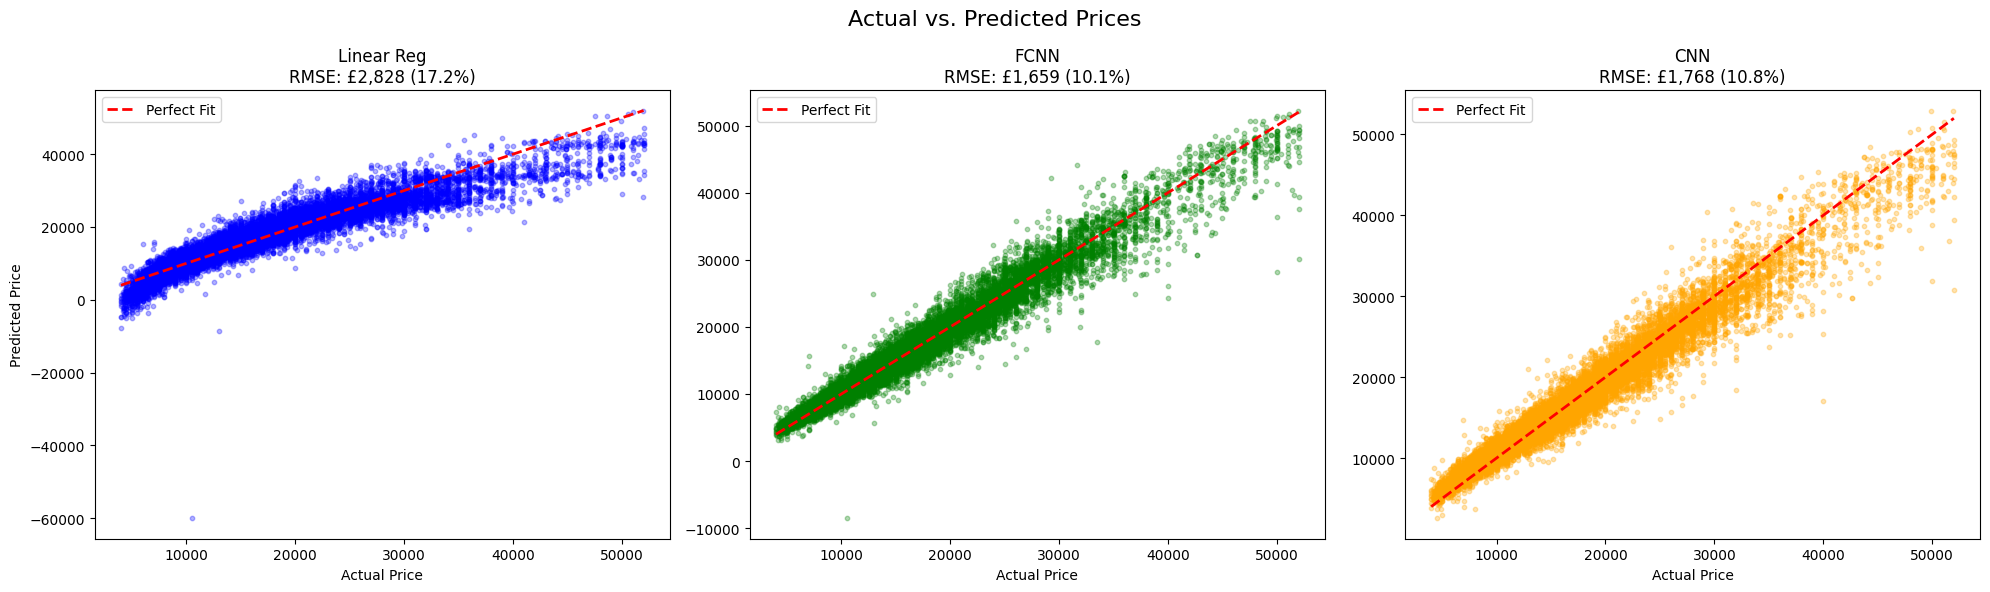

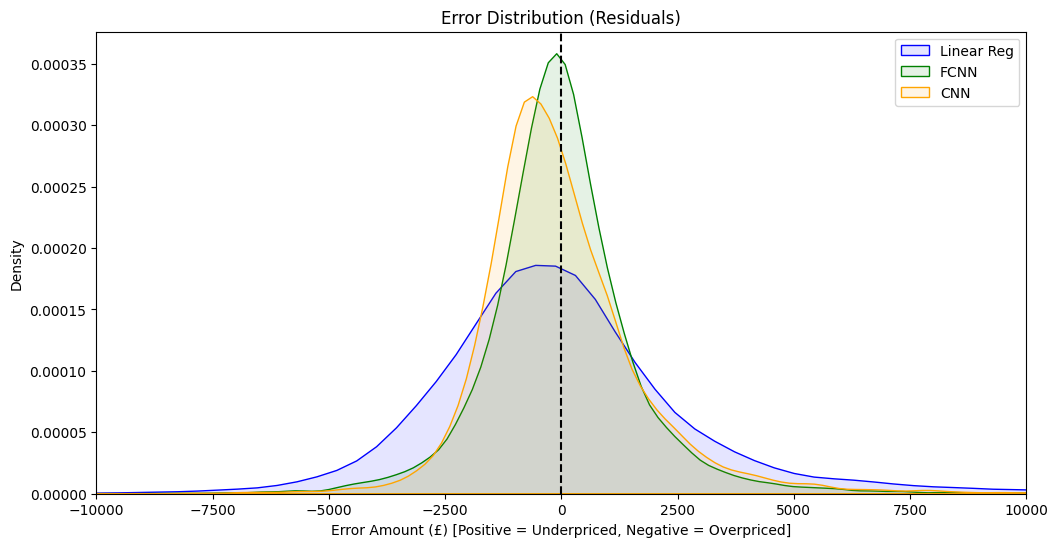

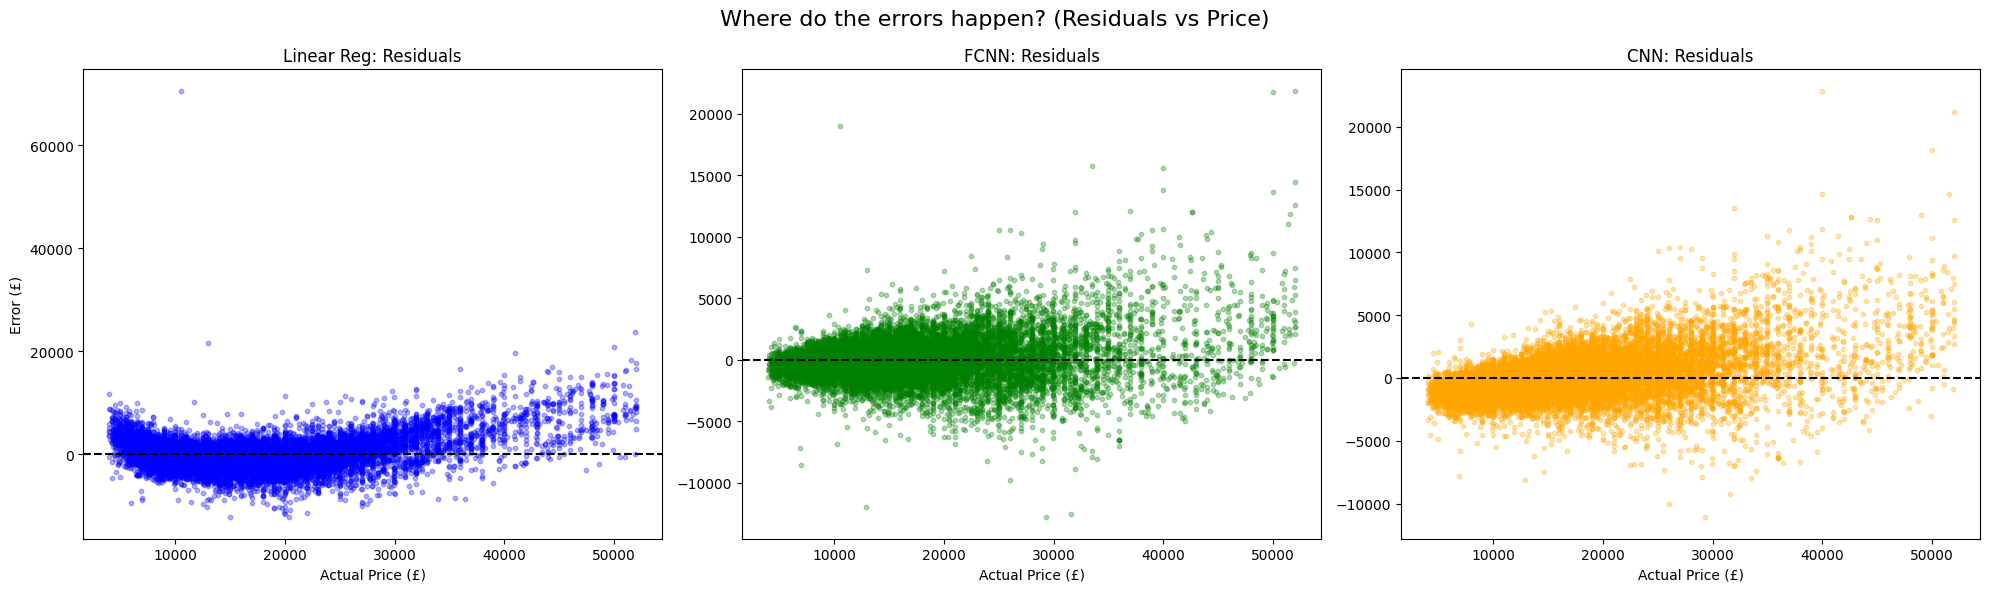

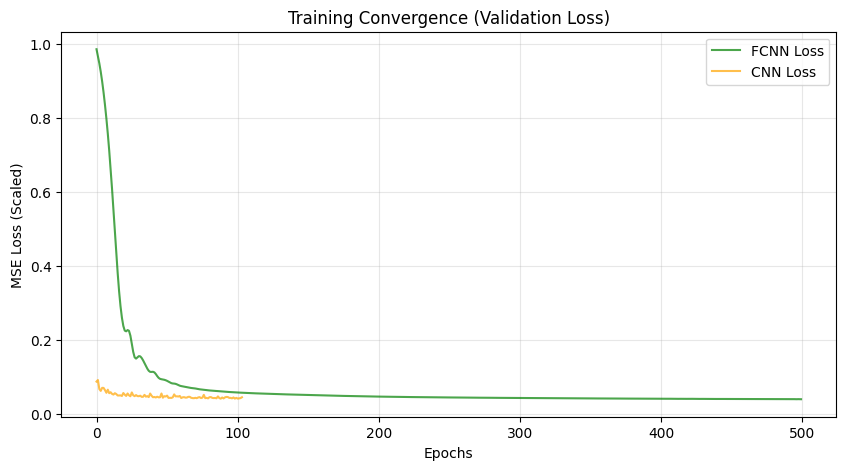

In [14]:
# --- BLOCK 7: ADVANCED ERROR VISUALIZATION ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch

print("--- Generating Advanced Error Analysis ---")

# 1. PREPARE DATA
# Ensure we have real values (not tensors)
y_real = y_test.values if hasattr(y_test, 'values') else y_test

# Get Predictions from all models
# Linear Regression
pred_lr = lr_model.predict(X_test)

# FCNN
model_fcnn.eval()
with torch.no_grad():
    p = model_fcnn(X_test_tensor).numpy()
    pred_fcnn = y_scaler.inverse_transform(p)

# CNN
model_cnn.eval()
with torch.no_grad():
    # Reshape input if needed
    cnn_in = X_test_tensor.unsqueeze(1) if X_test_tensor.ndim == 2 else X_test_tensor
    p = model_cnn(cnn_in).numpy()
    pred_cnn = y_scaler.inverse_transform(p)

# Organize into a Dictionary for looping
models_data = {
    'Linear Reg': {'pred': pred_lr, 'color': 'blue'},
    'FCNN':       {'pred': pred_fcnn, 'color': 'green'},
    'CNN':        {'pred': pred_cnn, 'color': 'orange'}
}

# Calculate Residuals (Actual - Predicted)
for name, data in models_data.items():
    data['residuals'] = y_real - data['pred'].flatten()
    data['abs_error'] = np.abs(data['residuals'])

# ==========================================
# PLOT 1: PREDICTION SCATTER (The Standard View)
# ==========================================
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, (name, data) in enumerate(models_data.items()):
    # RMSE Calculation
    rmse = np.sqrt(np.mean(data['residuals']**2))
    error_pct = (rmse / y_real.mean()) * 100

    # Plot
    axes[i].scatter(y_real, data['pred'], alpha=0.3, s=10, color=data['color'])
    axes[i].plot([y_real.min(), y_real.max()], [y_real.min(), y_real.max()], 'r--', lw=2, label='Perfect Fit')

    axes[i].set_title(f'{name}\nRMSE: £{rmse:,.0f} ({error_pct:.1f}%)')
    axes[i].set_xlabel('Actual Price')
    if i==0: axes[i].set_ylabel('Predicted Price')
    axes[i].legend()
plt.suptitle('Actual vs. Predicted Prices', fontsize=16)
plt.tight_layout()
plt.show()

# ==========================================
# PLOT 2: ERROR DISTRIBUTION (Histograms)
# ==========================================
# Ideally, these should be tall, thin bells centered at 0.
plt.figure(figsize=(12, 6))
for name, data in models_data.items():
    sns.kdeplot(data['residuals'], label=name, color=data['color'], fill=True, alpha=0.1)

plt.axvline(x=0, color='black', linestyle='--')
plt.title('Error Distribution (Residuals)')
plt.xlabel('Error Amount (£) [Positive = Underpriced, Negative = Overpriced]')
plt.ylabel('Density')
plt.xlim(-10000, 10000) # Zoom in to see the "bell" shape clearly
plt.legend()
plt.show()

# ==========================================
# PLOT 3: RESIDUALS VS PRICE (Heteroscedasticity)
# ==========================================
# Does the model get worse for expensive cars?
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
for i, (name, data) in enumerate(models_data.items()):
    axes[i].scatter(y_real, data['residuals'], alpha=0.3, s=10, color=data['color'])
    axes[i].axhline(y=0, color='black', linestyle='--')
    axes[i].set_title(f'{name}: Residuals')
    axes[i].set_xlabel('Actual Price (£)')
    if i==0: axes[i].set_ylabel('Error (£)')

plt.suptitle('Where do the errors happen? (Residuals vs Price)', fontsize=16)
plt.tight_layout()
plt.show()

# ==========================================
# PLOT 4: LEARNING CURVES
# ==========================================
plt.figure(figsize=(10, 5))
plt.plot(loss_history_fcnn, label='FCNN Loss', color='green', alpha=0.7)
plt.plot(loss_history_cnn, label='CNN Loss', color='orange', alpha=0.7)
plt.title('Training Convergence (Validation Loss)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss (Scaled)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()